In [1]:
# import networkx as nx
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [2]:
# 对称检查函数
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [3]:
# 网络数据导入为numpy数组
dataFile_1 = '../data/WS_2000_4_03.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'])
# network_physical = nx.Graph(data['A'])

dataFile_2 = '../data/WS_2000_4_03_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'])
# network_information = nx.Graph(data['A'])

# 数据检查
assert network_scale_1 == network_scale_2, "networks\' size don\'t match!"
assert check_symmetric(network_physical), "network_physical doesn\'t symmetry!"
assert check_symmetric(network_information), "network_information doesn\'t symmetry!"
if np.sum(np.sum(network_physical, axis=0)==0):
    print("The network is integral")

In [4]:
# 参数设置

# random.seed(256)       #指定生成“特定”的随机数
# np.random.seed(256)

# 0. 公共参数
Monte_Carlo_loop = 150      # 蒙特卡洛模拟次数
time_steps = 100           # 总时间步数
N = network_scale_1[0]     # 网络节点数

# # 1. SIS参数
# bata = 0.2    # 感染概率
# mu = 0.4      # 恢复概率

# Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N])       # N行代表时间步数，T列代表节点数，记录每步所有节点的感染状态

# infective_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步感染节点数,用于最终统计
# infective_count_average = np.zeros([1, time_steps])

# # 2. UAU参数
# lamda = 0.3    # 传播率
# delta = 0.6    # 遗忘率

# Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N])       # 存储网络中每个节点的知情状态快照

# awareness_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
# awareness_count_average = np.zeros([1, time_steps])

# 3. 节点警觉状态
# alert = 0.8
alerts = [0.1, 0.2, 0.4, 0.6, 0.8, 1]

# Node_alert = np.zeros([Monte_Carlo_loop, time_steps, N])      # 存储网络中每个节点的活跃状态快照
# alert_count = np.zeros([Monte_Carlo_loop, time_steps])        # 每步知晓节点数量,用于最终统计
# alert_count_average = np.zeros([1, time_steps])

# # 4. 其他参数
# aplha = 0.4      # 信息上传率
# sigma_S = 0.5    # S节点在知道信息后的防御系数/感染率衰减, 相当于减少与周围人的接触

# 5. 感染范围信息
i_t = np.zeros([len(alerts), time_steps])

In [5]:
time_start_outter = time.time()

for a in range(len(alerts)):
    alert = alerts[a]
    inalert = 1 - alert
    
    random.seed(256)       #指定生成“特定”的随机数
    np.random.seed(256)

    # 1. SIS参数
    bata = 0.2    # 感染概率
    mu = 0.4      # 恢复概率

    Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N])       # N行代表时间步数，T列代表节点数，记录每步所有节点的感染状态

    infective_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步感染节点数,用于最终统计
    infective_count_average = np.zeros([1, time_steps])

    # 2. UAU参数
    lamda = 0.3    # 传播率
    delta = 0.6    # 遗忘率

    Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N])       # 存储网络中每个节点的知情状态快照

    awareness_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    awareness_count_average = np.zeros([1, time_steps])

    # 3. 节点警觉状态
    # alert = 0.8
    # alerts = [0.1, 0.2, 0.4, 0.6, 0.8, 1]

    Node_alert = np.zeros([Monte_Carlo_loop, time_steps, N])      # 存储网络中每个节点的活跃状态快照
    alert_count = np.zeros([Monte_Carlo_loop, time_steps])        # 每步知晓节点数量,用于最终统计
    alert_count_average = np.zeros([1, time_steps])

    # 4. 其他参数
    aplha = 0.4      # 信息上传率
    sigma_S = 0.5    # S节点在知道信息后的防御系数/感染率衰减, 相当于减少与周围人的接触

    time_start_inner = time.time()
    for loop in range(Monte_Carlo_loop):

        # 是否必要选择一定比例节点用于初始化
        p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入
        Nodes_SIS[loop, 0, p] = 1     # 第一步标出初始感染节点的位置
        Nodes_UAU[loop, 0, p] = 1     # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

        # 初始节点依概率变得警觉
        p0 = np.random.rand(1)
        if p0 < alert:
            Node_alert[loop, 0, p] = 1    # 初始节点变得警觉


        # ----------开始时间步数模拟----------
        for t in range(time_steps-1):

            # ----------UAU演化----------
            for i in range(N):

                # 如果节点i是未知节点
                if Nodes_UAU[loop, t, i] == 0:
                    neighbor_total = np.where((network_information[i, :] == 1))[0]         # 查找其邻居
                    awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]            # 查找传播节点
                    neighbor_listener = np.intersect1d(awareness_nodes, neighbor_total)    # 取交集，真正可以传播它的邻居
                    Num_neighbor_listener = len(neighbor_listener)                         # 统计数量

                    # -----UAU传播过程-----
                    aware_rate = lamda
                    aware_temp = (1 - aware_rate) ** Num_neighbor_listener    # 最终计算的传播率
                    a1 = 1 - aware_temp

                    p = np.random.rand(1)
                    # 传播成功
                    if p <= a1:
                        Nodes_UAU[loop, t+1, i] = 1

                        # 已知的节点如果是非警觉的，节点依概率变得警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 已知的节点如果是警觉的，保持警觉
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A1!")

                    # 传播失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 0

                        # 继续保持U的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 已知的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A2!")


                # -----UAU遗忘过程-----
                elif Nodes_UAU[loop, t, i] == 1:

                    p = np.random.rand(1)
                    # 遗忘成功
                    if p <= delta:
                        Nodes_UAU[loop, t+1, i] = 0    # 这个节点遗忘

                        # 遗忘的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 遗忘的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A3!")

                    # 遗忘失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 1    # 遗忘失败，下个时刻节点保持知觉

                        # 遗忘失败且非警觉，依旧有概率变为警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 遗忘失败且已经警觉，警觉性保持不变（只有A->U才会变化） 
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A4!")   


            # ----------SIS演化----------
            for i in range(N):

                # 0代表易感(S)，如果节点i健康且非警觉，就查找其I状态的邻居（非警觉节点处理方式不变-与所有结节点触）
                if ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 0)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]            # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]            # 查找感染节点
                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)   # 取交集，真正可以感染它的邻居
                    Num_neighbor_infective = len(neighbor_infective)                       # 统计数量

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1                 # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective


                    # -----SIS感染过程1-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1

                            # 成功感染的节点下一时刻依概率变得警觉
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉
                            else:
                                Node_alert[loop, t+1, i] = 0
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                # 0代表易感(S)，如果节点i健康且警觉，就查找其I状态的警觉邻居
                elif ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 1)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 感染节点
                    alert_nodes = np.where((Node_alert[loop, t, :] == 0))[0]       # 非警觉节点

                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)          # 取交集，真正可以感染它的邻居
                    neighbor_infective_alert = np.intersect1d(neighbor_infective, alert_nodes)    # 取交集，真正可以感染它的警觉邻居

                    Num_neighbor_infective_alert = len(neighbor_infective_alert)                  # 统计

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1                 # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert


                    # -----SIS感染过程2-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                    # S节点已经是警觉节点，被感染后继续保持警觉
                    Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉

                # -----SIS康复过程-----
                elif Nodes_SIS[loop, t, i] == 1:

                    recover_rate_current = mu
                    p = np.random.rand(1) 
                    if p <= recover_rate_current:
                        Nodes_SIS[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 1

                else:
                    print("There is an else condition in SIS!")
            
        print("    loop_MC {} - time has passed: {} ".format(loop, time.time()-time_start_inner))

    # 处理数据
    for loop_ in range(Monte_Carlo_loop):
        infective_count[loop_,:] = np.sum(Nodes_SIS[loop_,:,:], axis=1)
        # awareness_count[loop_,:] = np.sum(Nodes_UAU[loop_,:,:], axis=1)
        # alert_count[loop_,:] = np.sum(Node_alert[loop_,:,:], axis=1)

    infective_count_average = np.mean(infective_count, axis=0)
    # awareness_count_average = np.mean(awareness_count, axis=0)
    # alert_count_average = np.mean(alert_count, axis=0)

    assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
    # assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"
    # assert alert_count_average.shape == (time_steps,), "alert_count_average\'s size don\'t match!"

    i_t_a = infective_count_average/N
    i_t[a] = i_t_a

    print("loop_a {} - time has passed: {} ".format(a, time.time()-time_start_outter))

    loop_MC 0 - time has passed: 30.284542083740234 
    loop_MC 1 - time has passed: 52.64330840110779 
    loop_MC 2 - time has passed: 72.62090468406677 
    loop_MC 3 - time has passed: 91.70386672019958 
    loop_MC 4 - time has passed: 110.7907989025116 
    loop_MC 5 - time has passed: 130.32949542999268 
    loop_MC 6 - time has passed: 151.0979723930359 
    loop_MC 7 - time has passed: 172.8517906665802 
    loop_MC 8 - time has passed: 192.09695601463318 
    loop_MC 9 - time has passed: 214.30758380889893 
    loop_MC 10 - time has passed: 236.96548199653625 
    loop_MC 11 - time has passed: 256.2491190433502 
    loop_MC 12 - time has passed: 276.14260840415955 
    loop_MC 13 - time has passed: 295.7003285884857 
    loop_MC 14 - time has passed: 311.169960975647 
    loop_MC 15 - time has passed: 329.5013771057129 
    loop_MC 16 - time has passed: 347.79854559898376 
    loop_MC 17 - time has passed: 365.92312026023865 
    loop_MC 18 - time has passed: 384.16983032226

    loop_MC 2 - time has passed: 58.84117007255554 
    loop_MC 3 - time has passed: 78.05748987197876 
    loop_MC 4 - time has passed: 97.35434460639954 
    loop_MC 5 - time has passed: 119.18800497055054 
    loop_MC 6 - time has passed: 137.7125518321991 
    loop_MC 7 - time has passed: 155.8860878944397 
    loop_MC 8 - time has passed: 174.7437436580658 
    loop_MC 9 - time has passed: 193.0183675289154 
    loop_MC 10 - time has passed: 212.1280403137207 
    loop_MC 11 - time has passed: 233.80013155937195 
    loop_MC 12 - time has passed: 252.17359161376953 
    loop_MC 13 - time has passed: 270.3711266517639 
    loop_MC 14 - time has passed: 289.12903475761414 
    loop_MC 15 - time has passed: 309.9293723106384 
    loop_MC 16 - time has passed: 330.73476696014404 
    loop_MC 17 - time has passed: 348.97561836242676 
    loop_MC 18 - time has passed: 369.57629346847534 
    loop_MC 19 - time has passed: 390.17794919013977 
    loop_MC 20 - time has passed: 412.25446701

    loop_MC 4 - time has passed: 106.22712659835815 
    loop_MC 5 - time has passed: 124.78144311904907 
    loop_MC 6 - time has passed: 143.2606520652771 
    loop_MC 7 - time has passed: 162.3193554878235 
    loop_MC 8 - time has passed: 181.0612599849701 
    loop_MC 9 - time has passed: 199.56608295440674 
    loop_MC 10 - time has passed: 223.35403490066528 
    loop_MC 11 - time has passed: 247.70338988304138 
    loop_MC 12 - time has passed: 270.20679664611816 
    loop_MC 13 - time has passed: 288.45013308525085 
    loop_MC 14 - time has passed: 306.6232557296753 
    loop_MC 15 - time has passed: 327.39123582839966 
    loop_MC 16 - time has passed: 349.30931401252747 
    loop_MC 17 - time has passed: 365.9976637363434 
    loop_MC 18 - time has passed: 384.4262719154358 
    loop_MC 19 - time has passed: 402.575323343277 
    loop_MC 20 - time has passed: 423.80127716064453 
    loop_MC 21 - time has passed: 444.2586979866028 
    loop_MC 22 - time has passed: 463.08833

    loop_MC 6 - time has passed: 134.22289085388184 
    loop_MC 7 - time has passed: 152.7323775291443 
    loop_MC 8 - time has passed: 168.00783276557922 
    loop_MC 9 - time has passed: 183.40220379829407 
    loop_MC 10 - time has passed: 205.55095672607422 
    loop_MC 11 - time has passed: 224.66832327842712 
    loop_MC 12 - time has passed: 243.10601663589478 
    loop_MC 13 - time has passed: 261.57628059387207 
    loop_MC 14 - time has passed: 280.5994396209717 
    loop_MC 15 - time has passed: 299.4973711967468 
    loop_MC 16 - time has passed: 317.651328086853 
    loop_MC 17 - time has passed: 336.21318435668945 
    loop_MC 18 - time has passed: 354.3262851238251 
    loop_MC 19 - time has passed: 372.3916037082672 
    loop_MC 20 - time has passed: 393.2059814929962 
    loop_MC 21 - time has passed: 415.65161180496216 
    loop_MC 22 - time has passed: 434.34670400619507 
    loop_MC 23 - time has passed: 454.0081021785736 
    loop_MC 24 - time has passed: 472.007

    loop_MC 8 - time has passed: 177.5725235939026 
    loop_MC 9 - time has passed: 196.40377640724182 
    loop_MC 10 - time has passed: 214.58872389793396 
    loop_MC 11 - time has passed: 236.2128884792328 
    loop_MC 12 - time has passed: 258.1457750797272 
    loop_MC 13 - time has passed: 279.90055799484253 
    loop_MC 14 - time has passed: 298.33235335350037 
    loop_MC 15 - time has passed: 316.76565074920654 
    loop_MC 16 - time has passed: 336.38271617889404 
    loop_MC 17 - time has passed: 357.9301393032074 
    loop_MC 18 - time has passed: 377.2290847301483 
    loop_MC 19 - time has passed: 395.14674615859985 
    loop_MC 20 - time has passed: 413.8538134098053 
    loop_MC 21 - time has passed: 432.52191185951233 
    loop_MC 22 - time has passed: 454.50916743278503 
    loop_MC 23 - time has passed: 472.8102345466614 
    loop_MC 24 - time has passed: 491.95402431488037 
    loop_MC 25 - time has passed: 510.4525544643402 
    loop_MC 26 - time has passed: 528.

    loop_MC 10 - time has passed: 205.26896953582764 
    loop_MC 11 - time has passed: 224.9443380832672 
    loop_MC 12 - time has passed: 246.87466835975647 
    loop_MC 13 - time has passed: 265.38716340065 
    loop_MC 14 - time has passed: 283.68370056152344 
    loop_MC 15 - time has passed: 302.47140526771545 
    loop_MC 16 - time has passed: 320.7515754699707 
    loop_MC 17 - time has passed: 341.7045238018036 
    loop_MC 18 - time has passed: 363.424400806427 
    loop_MC 19 - time has passed: 382.60512828826904 
    loop_MC 20 - time has passed: 400.77560234069824 
    loop_MC 21 - time has passed: 419.178973197937 
    loop_MC 22 - time has passed: 439.54948353767395 
    loop_MC 23 - time has passed: 461.2593870162964 
    loop_MC 24 - time has passed: 480.3684751987457 
    loop_MC 25 - time has passed: 498.4538161754608 
    loop_MC 26 - time has passed: 519.350020647049 
    loop_MC 27 - time has passed: 541.0968489646912 
    loop_MC 28 - time has passed: 560.196376

In [6]:
scio.savemat('../results/i_t_ws_ws_a2_new2.mat', {'i_t': i_t})

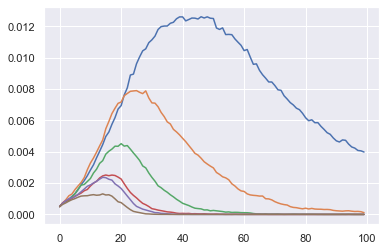

In [7]:
for aa in range(len(alerts)):
    plt.plot(i_t[aa])